技术分析是基于市场历史数据（价格、成交量等）预测未来价格涨跌的量化交易手段。本文以标普500指数为研究目标，完成基于趋势信号的交易系统的回测。

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
#pandas_datareader是一个远程获取金融数据的Python工具，通过它可以方便获得下面公司和机构的数据： Yahoo! Finance,Google Finance,Enigma,
#St.Louis FED (FRED),Kenneth French’s data library,World Bank,OECD,Eurostat,Thrift Savings Plan,Oanda currency historical rate,
#Nasdaq Trader symbol definitions
#安装方式，在anaconda prompt中输入pip install pandas_datareader

In [28]:
sp500=web.DataReader('^GSPC',data_source='yahoo',start='1/1/2000',end='10/1/2018')
#https://finance.yahoo.com/quote/%5EGSPC?ltr=1

In [29]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4718 entries, 1999-12-31 to 2018-10-01
Data columns (total 6 columns):
High         4718 non-null float64
Low          4718 non-null float64
Open         4718 non-null float64
Close        4718 non-null float64
Volume       4718 non-null int64
Adj Close    4718 non-null float64
dtypes: float64(5), int64(1)
memory usage: 258.0 KB


In [30]:
sp500['Close'].plot(grid=True,figsize=(8,5))#绘制收盘价的折线图

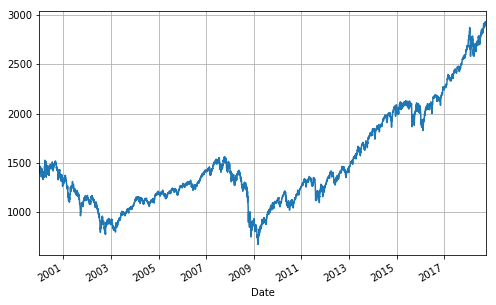

In [31]:
plt.show()

这里我们要实现的趋势策略是基于两个月（或42天）以及一年（即252天）的趋势（即，对应时期的指数水平的移动平均）。

下面分别生成对应的移动平均后的时间序列。

In [39]:
sp500['42d']=np.round(sp500['Close'].rolling(window=42,center=False).mean(),2)
sp500['252d']=np.round(sp500['Close'].rolling(window=252,center=False).mean(),2)

In [40]:
sp500[['Close','42d','252d']].tail()

,Close,42d,252d
Date,,,
2018-09-25,2915.560059,2870.53,2716.56
2018-09-26,2905.969971,2872.60,2718.18
2018-09-27,2914.000000,2875.25,2719.80
2018-09-28,2913.979980,2877.58,2721.40
2018-10-01,2924.590088,2880.23,2723.01


In [41]:
sp500[['Close','42d','252d']].plot(grid=True,figsize=(8,5))

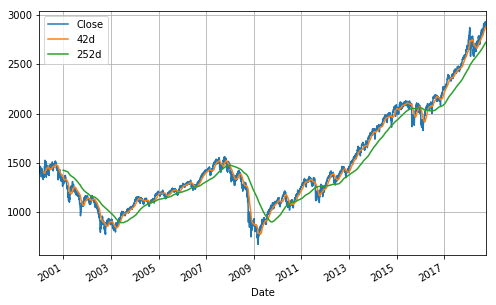

In [42]:
plt.show()

设置某种交易信号如下：
* 购买信号：42d的趋势第一次超过252d的趋势30个点
* 等待信号：42d的趋势保持在252d趋势的+/-30个点范围内
* 出售信号：42d的趋势第一次低于252d的趋势30个点

In [44]:
sp500['42-252']=sp500['42d']-sp500['252d']#交易信号数据列

In [45]:
sp500['42-252'].tail()

Date
2018-09-25    153.97
2018-09-26    154.42
2018-09-27    155.45
2018-09-28    156.18
2018-10-01    157.22
Name: 42-252, dtype: float64

In [46]:
sp500['42-252'].head()

Date
1999-12-31   NaN
2000-01-03   NaN
2000-01-04   NaN
2000-01-05   NaN
2000-01-06   NaN
Name: 42-252, dtype: float64

In [51]:
diff=30#交易信号阈值

In [52]:
#交易信号列，1买入，-1卖出
sp500['Regime']=np.where(sp500['42-252']>diff,1,0)
sp500['Regime']=np.where(sp500['42-252']<-diff,-1,sp500['Regime'])
sp500['Regime'].value_counts()#信号总数目

 1    2761
-1    1127
 0     830
Name: Regime, dtype: int64

In [53]:
sp500['Regime'].plot(lw=1.5)
plt.ylim([-1.1,1.1])

(-1.1, 1.1)

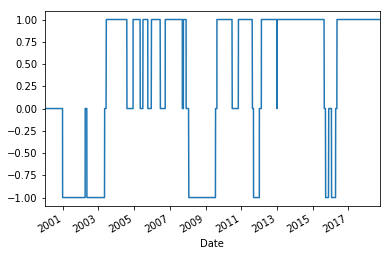

In [54]:
plt.show()

In [56]:
sp500['Market']=np.log(sp500['Close']/sp500['Close'].shift(1))
#Market列是SP500指数的对数收益率，使用shift函数,shift(1)向上平移一格
sp500['Strategy']=sp500['Regime'].shift(1)*sp500['Market']
#Strategy列是投资策略的收益
#基于上面相关的regimes，投资者可以持有指数的多头或者空头。
#当投资者多头指数的时候，他会获得正的市场收益，
#而当他持有指数的空头的时候，会获得负的市场收益，
#如果持有现金，则没有收益。
#交易头寸应当是“昨天”构造的，然后才会产生“今天”的收益，
#因此，应当由交易符号之后一天的数值去乘以收益率。

In [57]:
sp500[['Market','Strategy']].cumsum().apply(np.exp).plot(grid=True,figsize=(8,5))
#累计对数收益率曲线，再exp，即收益率

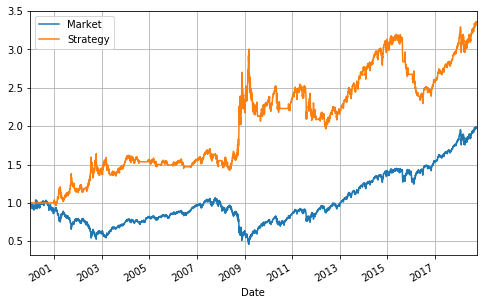

In [58]:
plt.show()

前面对交易的回测完全忽略了交易成本、操作因素和市场微观结构。例如，这里处理的是日度的收盘价格，有一定局限性。
策略的累计收益率远高于市场累计收益率的。